In [14]:
import os

import numpy as np
import pandas as pd
import torch

In [15]:
%cd /workspace/EmotionShortForm/data_concatenate

/workspace/EmotionShortForm/data_concatenate


In [16]:
concatenate_vit_features = np.load('concatenate_vit_features_array.npy', allow_pickle=True)
concatenate_audio_features = np.load('concatenate_features_array.npy', allow_pickle=True)
labels = np.load('labels.npy', allow_pickle=True)

In [17]:
print(concatenate_vit_features.shape)
print(concatenate_audio_features.shape)

(556,)
(556,)


In [18]:
print(concatenate_vit_features[64].shape)
print(concatenate_audio_features[64].shape)

torch.Size([250, 768])
torch.Size([250, 128])


In [19]:
features_concatenate_list = []
cnt = 0
max_seq_len = 896
for vit_features, audio_features in zip(concatenate_vit_features, concatenate_audio_features):
    if len(vit_features.cuda()) == len(audio_features):
        concated_feature = torch.cat((vit_features.cuda(), audio_features), dim=1)
    elif len(vit_features.cuda()) > len(audio_features):
        # Split into columns of size 2
        pad = torch.zeros((len(vit_features.cuda())-len(audio_features), 128))
        audio_features = torch.cat((audio_features, pad), dim=0)
        concated_feature =torch.cat((vit_features.cuda(), audio_features), dim=1)
        print(f'check1: {concated_feature.shape}')
    elif len(vit_features.cuda()) < len(audio_features):
        pad = torch.zeros((len(audio_features)-len(vit_features.cuda()), 768))
        vit_features = torch.cat((vit_features.cuda(), pad.cuda()), dim=0)
        concated_feature =torch.cat((vit_features.cuda(), audio_features), dim=1)
        print(f'check2: {concated_feature.shape}')
    features_concatenate_list.append(concated_feature)

check2: torch.Size([224, 896])
check2: torch.Size([85, 896])
check2: torch.Size([88, 896])
check2: torch.Size([75, 896])
check2: torch.Size([202, 896])
check2: torch.Size([245, 896])


In [20]:
len(features_concatenate_list), len(features_concatenate_list[2]), features_concatenate_list[0].shape

(556, 202, torch.Size([250, 896]))

In [21]:
labels.shape

(556,)

In [22]:
total = 0
for i in range(len(features_concatenate_list)):
    total+=  len(features_concatenate_list[i])
total

120256

In [23]:
c = [i.tolist() for i in features_concatenate_list]
c = sum(c,[])

TypeError: 'int' object is not callable

In [ ]:
l = labels.tolist()
l = [i.tolist() for i in labels]
l_list = sum(l,[])

In [ ]:
len(l_list)

# Dataset, DataLoader

In [ ]:
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

In [ ]:
class MyDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        
    def __len__(self):
        return len(self.data)
        
    def __getitem__(self, idx):
        return self.data[idx], torch.tensor(self.labels[idx])

In [ ]:
# Create an instance of dataset
md = MyDataset(features_concatenate_list,labels)
len(md), md[2][0].shape

### features_concatenate_list, Labels 개수 맞추기

In [32]:
diff_idx = []
for i in range(len(features_concatenate_list)):
    if len(features_concatenate_list[i]) != len(labels[i]):
        diff_idx.append(i)
    else:
        continue

diff_idx

[164, 236, 356, 359, 406, 420]

In [33]:
len(features_concatenate_list[164]), len(labels[164])

(111, 106)

In [38]:
len(features_concatenate_list[236]), len(labels[236])

len(features_concatenate_list[356]), len(labels[356]) ##

len(features_concatenate_list[359]), len(labels[359])

len(features_concatenate_list[406]), len(labels[406])

len(features_concatenate_list[420]), len(labels[420]) ##

(86, 87)

In [39]:
#### 인덱스 개수 맞추기
new_features_concatenate_list = []
new_labels = []
for concat, label in zip(features_concatenate_list, labels):
    if len(concat.cuda()) == len(label):
        new_features_concatenate_list.append(concat)
        new_labels.append(label)
    elif len(concat.cuda()) > len(label):
        # Split into columns of size 2
        idx = len(label)
        new_concat = concat[0:idx,:]
        new_features_concatenate_list.append(new_concat)
        new_labels.append(label)
        print(f'check1: {new_concat.shape}, {label.shape}')
    elif len(concat.cuda()) < len(label):
        idx = len(concat)
        new_label = label[0:idx]
        new_features_concatenate_list.append(concat)
        new_labels.append(new_label)
        print(f'check2: {concat.shape}, {new_label.shape}')

check1: torch.Size([106, 896]), (106,)
check1: torch.Size([177, 896]), (177,)
check2: torch.Size([236, 896]), (236,)
check1: torch.Size([111, 896]), (111,)
check1: torch.Size([171, 896]), (171,)
check2: torch.Size([86, 896]), (86,)


In [65]:
label_dict = {}
idx = 0
for i in range(len(new_labels)):
    for j in range(len(new_labels[i])):
        label = new_labels[i][j] # 데이터셋 md의 i번째 데이터의 레이블 값을 가져옵니다.
        if label not in label_dict:
            label_dict[label] = []
        label_dict[label].append(idx)
        idx +=1

In [68]:
len(label_dict[0]), len(label_dict[1])

(78637, 41591)

### Undersampling

In [43]:
import random
random.seed(42)

undersampled_idxs = []
for label in label_dict:
    # 언더샘플링할 데이터 개수를 결정합니다. (예: 100개)
    num_samples = 41591
    if len(label_dict[label]) <= num_samples:# 1
        # 해당 레이블의 데이터가 num_samples 이하라면 모두 선택합니다.
        undersampled_idxs += label_dict[label]
    else: # 0
        # 해당 레이블의 데이터가 num_samples 보다 많으면 무작위로 num_samples개를 선택합니다.
        undersampled_idxs += random.sample(label_dict[label], num_samples)

undersampled_idxs.sort() #인덱스 순 정렬
undersampled_idxs

[0,
 3,
 4,
 5,
 6,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 80,
 81,
 85,
 86,
 88,
 89,
 91,
 94,
 96,
 97,
 98,
 99,
 100,
 101,
 103,
 105,
 106,
 107,
 108,
 109,
 110,
 114,
 116,
 117,
 119,
 123,
 126,
 127,
 128,
 131,
 134,
 135,
 137,
 138,
 140,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 188,
 189,
 190,
 191,
 192,
 193,
 195,
 198,
 200,
 201,
 205,
 208,
 211,
 218,
 220,
 222,
 224,
 225,
 226,
 227,
 230,
 231,
 233,
 234,
 237,
 238,
 239,
 240,
 242,
 245,
 246,
 252,
 

In [44]:
#### Undersampling
under_features_concatenate_list = []
under_labels = []
idx = 0
for concat, label in zip(new_features_concatenate_list, new_labels):
    temp_features = []
    temp_labels = []
    for i in range(len(concat)): # 250,250,202,...
        if idx in undersampled_idxs:
            temp_features.append(concat[i,:])
            temp_labels.append(label[i])
        idx += 1    
    under_features_concatenate_list.append(torch.stack(temp_features))
    under_labels.append(torch.tensor(temp_labels))
    
       

In [45]:
len(under_features_concatenate_list),under_features_concatenate_list[0].shape  

(556, torch.Size([181, 896]))

In [46]:
len(under_labels),under_labels[0].shape

(556, torch.Size([181]))

### Train, test split

In [47]:
new_md = MyDataset(under_features_concatenate_list,under_labels)
len(new_md), new_md[0][0].shape

<ipython-input-12-e75d77e92481>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.data[idx], torch.tensor(self.labels[idx])


(556, torch.Size([181, 896]))

In [55]:
# train, test split
train_idx, val_idx = train_test_split(range(len(new_md)), test_size=0.2, random_state = 42)

In [56]:
print(len(train_idx))
print(len(val_idx))

444
112


In [57]:
train_dataset = torch.utils.data.Subset(new_md, train_idx)
train_dataloader = DataLoader(train_dataset)

val_dataset = torch.utils.data.Subset(new_md, val_idx)
val_dataloader = DataLoader(val_dataset)

# Model

In [58]:
import torch
import torch.nn as nn

class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        # Set initial hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))
        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        
        output = self.sigmoid(out)
        
        return output, out


# Training

In [345]:
num_epochs = 500
learning_rate = 0.0001

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

input_size = 896
hidden_size = 128
num_layers = 3
output_size = 1

model = LSTMClassifier(input_size, hidden_size, num_layers, output_size).to(device)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) #SGD(model.parameters(), learning_rate,momentum=0.9,weight_decay=1e-4) 

In [6]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.total = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.total += val * n
        self.count += n
        self.avg = self.total / self.count
 

In [9]:
def fmeasure(output, target, threshold):
    pred = (output > threshold).long() # 예측값을 threshold 기준으로 0 또는 1로 바꿔줍니다.

    TP = torch.sum(torch.logical_and(pred == 1, target == 1)).item()
    FP = torch.sum(torch.logical_and(pred == 1, target == 0)).item()
    TN = torch.sum(torch.logical_and(pred == 0, target == 0)).item()
    FN = torch.sum(torch.logical_and(pred == 0, target == 1)).item()
    
    pred_len = pred.sum().item()
    gt_len = target.sum().item()

    return TP, FP, TN, FN, pred_len, gt_len, pred


In [350]:
### train, test 나눠서 성능 측정 - f1 score

from tqdm.notebook import tqdm_notebook
# LSTM ADAM

weight_dir = '/workspace/EmotionShortForm/lstm/model/weight/'

with open('/workspace/EmotionShortForm/lstm/results/train_result','a') as f:
    f.write('=====lstm result=======\n')
f1_best=0
for epoch in range(num_epochs):
    running_loss = 0.0
    model.train()
    for inputs, labels in tqdm_notebook(train_dataloader, total=len(train_dataloader), desc='Training'):
        if inputs.shape[1]!= labels.shape[1] : continue
        
        inputs = inputs.transpose(0,1).to(device)
        labels = labels.squeeze(0).to(device)
        
        optimizer.zero_grad()
        
        # Forward pass
        # print(inputs[:20])
        # print(inputs.shape)
        outputs,out = model(inputs)
        outputs = outputs.squeeze(1)
        # print()
        # print(outputs[:20])
        
        #print(f'outputs:{outputs.shape}, labels:{labels.shape}')
        
        loss = criterion(outputs, labels.float())

        # Backward and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, running_loss/len(dataloader)))
    
    model.eval()
    val_losses=AverageMeter()
    acc=0
    gt_sum=0
    tp_sum=0
    fp_sum=0
    fn_sum=0
    thres = 0.2
    acc=0
    sum=0
    pred_sum=0
    with open('/workspace/EmotionShortForm/lstm/results/train_result','a') as f:
        with torch.no_grad():
            for inputs, labels in tqdm_notebook(val_dataloader, total=len(val_dataloader), desc='Validation'):
                if inputs.shape[1]!= labels.shape[1] : continue
                inputs = inputs.transpose(0,1).to(device)
                labels = labels.squeeze(0).to(device)
                outputs,out = model(inputs)
                
                # print(f'outputs.shape: {outputs.shape}, labels.shape: {labels.shape}')
                
                loss=criterion(outputs.squeeze(1),labels.float())
                val_losses.update(loss,labels.size(0))
                
                TP,FP,TN,FN,pred_len, gt_len,pred=fmeasure(outputs.squeeze(1).cpu(),labels.cpu(),thres)
                # print("TP: ",TP,"FP: ", FP,"TN: ", TN,"FN", FN,pred_len, gt_len)
                tp_sum += TP
                fp_sum += FP
                fn_sum += FN
                pred_sum += pred_len
                gt_sum += gt_len
                acc=acc+TP+TN
                sum+=len(out)
            if tp_sum>0 and fp_sum>0 and fn_sum>0:
                precision = tp_sum/(tp_sum+fp_sum)
                recall = tp_sum / (tp_sum+fn_sum)
                f1 = (2*precision*recall / (precision + recall))
                accuracy=acc/sum
                print("epoch  [{}/{}], train_loss : {} , val_loss : {},p {}, r {}, f {}\n".format(epoch+1, num_epochs, running_loss/len(train_dataloader),val_losses.avg,precision,recall,f1))
                f.write("epoch  [{}/{}], train_loss : {} , val_loss : {},p {}, r {}, f {}\n".format(epoch+1, num_epochs, running_loss/len(train_dataloader),val_losses.avg,precision,recall,f1))
                torch.save(model.state_dict(),'{}.pt'.format(weight_dir+str(epoch)+"_train"))
                if f1_best<f1:
                    f.write("== best epoch {} train_loss : {} , val_loss : {},p {}, r {}, f {}\n".format(epoch+1, num_epochs,running_loss/len(train_dataloader),val_losses.avg,precision,recall,f1))
                    torch.save(model.state_dict(),'/workspace/EmotionShortForm/lstm/model/{}.pt'.format(str(epoch)+"_best"))
                    f1_best=f1
            else:
                print("epoch  [{}/{}], train_loss : {} , val_loss : {},p {}, r {}, f {}\n".format(epoch+1, num_epochs,running_loss/len(train_dataloader),val_losses.avg,0,0,0))
                f.write("epoch [{}/{}], train_loss : {} , val_loss : {},p {}, r {}, f {}\n".format(epoch+1, num_epochs,running_loss/len(train_dataloader),val_losses.avg,0,0,0))
#                 torch.save(model.state_dict(),'/workspace/EmotionShortForm/lstm/model/{}.pt'.format(str(epoch)+"train"))        
        

Training:   0%|          | 0/444 [00:00<?, ?it/s]

<ipython-input-129-e75d77e92481>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.data[idx], torch.tensor(self.labels[idx])


Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [1/500], train_loss : 0.6247856797113478 , val_loss : 0.7525318264961243,p 0.48423089326023866, r 0.9533968253968254, f 0.6422583404619332



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [2/500], train_loss : 0.6239593235591242 , val_loss : 0.7568721771240234,p 0.48426087518583155, r 0.9513650793650794, f 0.6418230103658015



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [3/500], train_loss : 0.6222995518295614 , val_loss : 0.7610676884651184,p 0.4844053319528925, r 0.9506031746031746, f 0.6417763298898367



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [4/500], train_loss : 0.620600176173858 , val_loss : 0.7653136849403381,p 0.48461687933156294, r 0.9500952380952381, f 0.64184610105516



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [5/500], train_loss : 0.6188726306993615 , val_loss : 0.7696381211280823,p 0.4844378161068603, r 0.9486984126984127, f 0.6413701334935827



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [6/500], train_loss : 0.6171244252347261 , val_loss : 0.7740015983581543,p 0.48435471306154243, r 0.9474285714285714, f 0.6410069161046436



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [7/500], train_loss : 0.6153598297932731 , val_loss : 0.7784152030944824,p 0.48429676832043694, r 0.9457777777777778, f 0.6405779650812763



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [8/500], train_loss : 0.6135823421121516 , val_loss : 0.782855749130249,p 0.48418174716833745, r 0.9445079365079365, f 0.6401859104015148



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [9/500], train_loss : 0.6117948794963997 , val_loss : 0.7872956395149231,p 0.4845421340986173, r 0.9433650793650794, f 0.6402378592666006



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [10/500], train_loss : 0.6099985111546745 , val_loss : 0.7917543649673462,p 0.4846249265521969, r 0.9426031746031746, f 0.640134529147982



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [11/500], train_loss : 0.6082047286510535 , val_loss : 0.7961714267730713,p 0.4846324875752027, r 0.9410793650793651, f 0.639789355548841



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [12/500], train_loss : 0.6064050906874776 , val_loss : 0.8005797863006592,p 0.4844773382237359, r 0.9393015873015873, f 0.6392429676360022



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [13/500], train_loss : 0.6046068287907621 , val_loss : 0.8049548864364624,p 0.48434114634626746, r 0.9367619047619048, f 0.638535445338873



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [14/500], train_loss : 0.6028059075821426 , val_loss : 0.8092872500419617,p 0.484256885558404, r 0.9354920634920635, f 0.6381670131670132



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [15/500], train_loss : 0.6010132982596956 , val_loss : 0.8135530352592468,p 0.48407475651487236, r 0.9340952380952381, f 0.6376836721425166



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [16/500], train_loss : 0.599215933371352 , val_loss : 0.817784309387207,p 0.48399209486166006, r 0.932952380952381, f 0.6373454782042941



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [17/500], train_loss : 0.5974180537426995 , val_loss : 0.8219491243362427,p 0.48384331310999734, r 0.9316825396825397, f 0.6369200052085594



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [18/500], train_loss : 0.5956279992541248 , val_loss : 0.8260374069213867,p 0.4837516512549538, r 0.930031746031746, f 0.6364544862046492



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [19/500], train_loss : 0.5938387315359537 , val_loss : 0.8300748467445374,p 0.48382615598333, r 0.9287619047619048, f 0.6362212943632568



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [20/500], train_loss : 0.5920379984188355 , val_loss : 0.8340511918067932,p 0.48393933373071063, r 0.9278730158730158, f 0.6361103856533472



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [21/500], train_loss : 0.5902470395782845 , val_loss : 0.8379716277122498,p 0.48377678986132305, r 0.9258412698412698, f 0.6354920247537696



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [22/500], train_loss : 0.5884576850530885 , val_loss : 0.8418545126914978,p 0.4838795453034634, r 0.9243174603174603, f 0.6352212234924514



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [23/500], train_loss : 0.586659839019171 , val_loss : 0.84571772813797,p 0.4841782692692026, r 0.9229206349206349, f 0.6351481254915669



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [24/500], train_loss : 0.5848678460067792 , val_loss : 0.849514365196228,p 0.4839484749382634, r 0.9207619047619048, f 0.6344387085484294



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [25/500], train_loss : 0.5830780704891695 , val_loss : 0.853323221206665,p 0.4840564208837489, r 0.9194920634920635, f 0.6342296575282473



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [26/500], train_loss : 0.5812836968725933 , val_loss : 0.8571308255195618,p 0.48413229780396355, r 0.9182222222222223, f 0.6339923721011793



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [27/500], train_loss : 0.5794882133334607 , val_loss : 0.8609490990638733,p 0.4842147597023929, r 0.9173333333333333, f 0.6338510134245854



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [28/500], train_loss : 0.5776839593780931 , val_loss : 0.8647891283035278,p 0.48446412992416615, r 0.9166984126984127, f 0.6339128907622058



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [29/500], train_loss : 0.5758659564753625 , val_loss : 0.868682324886322,p 0.48443069473401035, r 0.9146666666666666, f 0.633397819205065



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [30/500], train_loss : 0.5740512954071164 , val_loss : 0.8726381063461304,p 0.48450134770889486, r 0.9130158730158731, f 0.6330618534008364



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [31/500], train_loss : 0.5722166877161283 , val_loss : 0.876640796661377,p 0.4848178137651822, r 0.9123809523809524, f 0.6331791143423663



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [32/500], train_loss : 0.570386195686952 , val_loss : 0.880739152431488,p 0.4849652003513751, r 0.9113650793650794, f 0.6330598923877568



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [33/500], train_loss : 0.568551042372558 , val_loss : 0.8848613500595093,p 0.4850453376640953, r 0.9102222222222223, f 0.632852160861696



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [34/500], train_loss : 0.5667113095240328 , val_loss : 0.8890187740325928,p 0.4849942415825486, r 0.909079365079365, f 0.6325322495140484



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [35/500], train_loss : 0.5648724389601255 , val_loss : 0.8932613134384155,p 0.4851034950797421, r 0.9076825396825396, f 0.6322865988500663



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [36/500], train_loss : 0.5630242269644031 , val_loss : 0.8974736332893372,p 0.4855220228384992, r 0.9070476190476191, f 0.6324877141718688



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [37/500], train_loss : 0.5611837044647194 , val_loss : 0.9017466902732849,p 0.48553142234629265, r 0.9055238095238095, f 0.6321248116301746



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [38/500], train_loss : 0.5593424612826139 , val_loss : 0.9061041474342346,p 0.48554676847559314, r 0.9043809523809524, f 0.6318591136938296



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [39/500], train_loss : 0.5574968449369194 , val_loss : 0.9104657173156738,p 0.4861357738013933, r 0.9038730158730158, f 0.6322334236354754



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [40/500], train_loss : 0.5556533045466069 , val_loss : 0.9148528575897217,p 0.4864957264957265, r 0.9034920634920635, f 0.6324444444444445



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [41/500], train_loss : 0.5538195541439481 , val_loss : 0.9192485213279724,p 0.486808743918317, r 0.9020952380952381, f 0.632366031689514



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [42/500], train_loss : 0.5519809023971902 , val_loss : 0.923651397228241,p 0.48690525161113396, r 0.9018412698412699, f 0.632385022928632



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [43/500], train_loss : 0.5501422136535644 , val_loss : 0.9280432462692261,p 0.487123137147174, r 0.9006984126984127, f 0.6322873952576217



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [44/500], train_loss : 0.5483213833057734 , val_loss : 0.9325078725814819,p 0.4867299229922992, r 0.8989206349206349, f 0.6315179089165439



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [45/500], train_loss : 0.5464875513967231 , val_loss : 0.9369107484817505,p 0.4870152235310326, r 0.8977777777777778, f 0.6314755269739193



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [46/500], train_loss : 0.5446623544314764 , val_loss : 0.9414087533950806,p 0.4868520946925254, r 0.8957460317460317, f 0.6308352709712037



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [47/500], train_loss : 0.5428225242146443 , val_loss : 0.9460117220878601,p 0.48696494018394304, r 0.8942222222222223, f 0.6305515759312321



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [48/500], train_loss : 0.5409710517399346 , val_loss : 0.9506643414497375,p 0.48673547135831546, r 0.8923174603174603, f 0.6298852635353174



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [49/500], train_loss : 0.5391147195946646 , val_loss : 0.955481231212616,p 0.48685214736696036, r 0.8910476190476191, f 0.6296661880832735



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [50/500], train_loss : 0.5372603259127098 , val_loss : 0.9604303240776062,p 0.4870120850118072, r 0.8904126984126984, f 0.6296412696987383



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [51/500], train_loss : 0.5354041036439371 , val_loss : 0.9654297232627869,p 0.4871919810664068, r 0.8887619047619048, f 0.6293781754417518



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [52/500], train_loss : 0.533522491789021 , val_loss : 0.9705435633659363,p 0.48761771886989885, r 0.8876190476190476, f 0.6294461954074742



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [53/500], train_loss : 0.531654641229358 , val_loss : 0.9759102463722229,p 0.4876771626055994, r 0.886984126984127, f 0.6293359762140734



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [54/500], train_loss : 0.5297844345639549 , val_loss : 0.9811980128288269,p 0.4877264144345758, r 0.8855873015873016, f 0.6290249842157482



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [55/500], train_loss : 0.5279076759232192 , val_loss : 0.9867735505104065,p 0.4879159369527145, r 0.8844444444444445, f 0.6288939051918736



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [56/500], train_loss : 0.5260342124677393 , val_loss : 0.9921500086784363,p 0.48792134831460676, r 0.8822857142857143, f 0.628351797422564



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [57/500], train_loss : 0.5241415295561941 , val_loss : 0.9978278875350952,p 0.4877619918413279, r 0.8806349206349207, f 0.627800660842801



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [58/500], train_loss : 0.5222653854225182 , val_loss : 1.003322958946228,p 0.4879046477184569, r 0.8784761904761905, f 0.627369184728394



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [59/500], train_loss : 0.5203561036494254 , val_loss : 1.0094319581985474,p 0.487758413885557, r 0.8778412698412699, f 0.6270863570391871



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [60/500], train_loss : 0.5186210821193281 , val_loss : 1.0138956308364868,p 0.4880555752463316, r 0.8742857142857143, f 0.6264216176871986



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [61/500], train_loss : 0.5170573651791799 , val_loss : 1.0251107215881348,p 0.48763523956723337, r 0.8813968253968254, f 0.6278890949387127



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [62/500], train_loss : 0.5217728077475283 , val_loss : 1.0052380561828613,p 0.4880321054894654, r 0.8647619047619047, f 0.6239406294379036



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [63/500], train_loss : 0.5176200874419272 , val_loss : 1.0146839618682861,p 0.4876357267950963, r 0.8839365079365079, f 0.6285327313769752



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [64/500], train_loss : 0.512928425608242 , val_loss : 1.024344563484192,p 0.48788752703677, r 0.8593015873015873, f 0.622395953092665



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [65/500], train_loss : 0.5099189492264584 , val_loss : 1.019604206085205,p 0.4881956752924495, r 0.8744126984126984, f 0.6265696087352138



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [66/500], train_loss : 0.5094124934756535 , val_loss : 1.0355210304260254,p 0.4873457878040183, r 0.8778412698412699, f 0.626745240253853



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [67/500], train_loss : 0.5071996455038118 , val_loss : 1.046732783317566,p 0.48771049802938016, r 0.8642539682539683, f 0.6235455794777829



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [68/500], train_loss : 0.507712311543249 , val_loss : 1.0568879842758179,p 0.48643559522979285, r 0.8857142857142857, f 0.6279823534707842



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [69/500], train_loss : 0.5029559481977763 , val_loss : 1.0648417472839355,p 0.48868778280542985, r 0.8365714285714285, f 0.6169694699381907



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [70/500], train_loss : 0.503213646922857 , val_loss : 1.0728791952133179,p 0.48707076324204085, r 0.8897777777777778, f 0.6295314675890571



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [71/500], train_loss : 0.5092161570081042 , val_loss : 1.0601285696029663,p 0.4884590019784568, r 0.8464761904761905, f 0.6194591580708113



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [72/500], train_loss : 0.5006851345972848 , val_loss : 1.0788896083831787,p 0.48639526072880074, r 0.8966349206349207, f 0.630671668453019



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [73/500], train_loss : 0.5028656988422324 , val_loss : 1.0655404329299927,p 0.4884517304189435, r 0.8513015873015873, f 0.6207407407407408



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [74/500], train_loss : 0.4971014241020327 , val_loss : 1.0795806646347046,p 0.4864154856550294, r 0.8934603174603175, f 0.6299015219337512



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [75/500], train_loss : 0.5010771956477391 , val_loss : 1.0639228820800781,p 0.48760630951515593, r 0.8518095238095238, f 0.6201923076923077



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [76/500], train_loss : 0.49411430632585096 , val_loss : 1.0787677764892578,p 0.4865262126408623, r 0.8826666666666667, f 0.6272899557801642



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [77/500], train_loss : 0.494236956110663 , val_loss : 1.0686091184616089,p 0.4886622147207749, r 0.8455873015873016, f 0.6193842433262021



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [78/500], train_loss : 0.49365067814691477 , val_loss : 1.0435640811920166,p 0.4874876985800647, r 0.8806349206349207, f 0.627573412967739



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [79/500], train_loss : 0.4935764240221451 , val_loss : 1.0632165670394897,p 0.48765999575701857, r 0.8756825396825397, f 0.626453488372093



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [80/500], train_loss : 0.48833430057410426 , val_loss : 1.079251766204834,p 0.48668989547038327, r 0.8868571428571429, f 0.6284814398200225



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [81/500], train_loss : 0.4870058350714732 , val_loss : 1.091001272201538,p 0.48728246318607765, r 0.8782222222222222, f 0.62678992205909



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [82/500], train_loss : 0.48157128480996514 , val_loss : 1.1057151556015015,p 0.4881678281068525, r 0.8539682539682539, f 0.6212184194725416



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [83/500], train_loss : 0.4820555696468605 , val_loss : 1.1143014430999756,p 0.48662551440329216, r 0.900952380952381, f 0.631930527722111



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [84/500], train_loss : 0.488295058638117 , val_loss : 1.1156108379364014,p 0.4896930484501956, r 0.8265396825396826, f 0.615013936788397



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [85/500], train_loss : 0.48621023232656907 , val_loss : 1.1024810075759888,p 0.4869077732959595, r 0.9043809523809524, f 0.6330103990756377



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [86/500], train_loss : 0.4921939688709896 , val_loss : 1.0827258825302124,p 0.48687350835322196, r 0.8548571428571429, f 0.6204036494332319



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [87/500], train_loss : 0.4809163653891664 , val_loss : 1.1200333833694458,p 0.4865819688837557, r 0.9094603174603174, f 0.6339736213153935



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [88/500], train_loss : 0.4857956134480891 , val_loss : 1.0978082418441772,p 0.48755066589461493, r 0.8553650793650793, f 0.6210870868101978



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [89/500], train_loss : 0.478381751040394 , val_loss : 1.102157473564148,p 0.48685899601378285, r 0.915047619047619, f 0.6355618274828012



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [90/500], train_loss : 0.4844156640646315 , val_loss : 1.1072434186935425,p 0.48866146370195845, r 0.8427936507936508, f 0.6186326140653399



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [91/500], train_loss : 0.4747471054691038 , val_loss : 1.1062992811203003,p 0.48746252384846006, r 0.9084444444444445, f 0.6344729723737307



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [92/500], train_loss : 0.47740049893116093 , val_loss : 1.1243845224380493,p 0.4894861543017918, r 0.8394920634920635, f 0.6183995135868294



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [93/500], train_loss : 0.46899898792018757 , val_loss : 1.1296418905258179,p 0.48671142817177226, r 0.8836825396825397, f 0.6277003562891805



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [94/500], train_loss : 0.470268671896715 , val_loss : 1.136864185333252,p 0.48816763132830243, r 0.8460952380952381, f 0.6191228396208883



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [95/500], train_loss : 0.47005605031551023 , val_loss : 1.1088021993637085,p 0.4865266284744324, r 0.8735238095238095, f 0.6249659307713273



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [96/500], train_loss : 0.48120527836291305 , val_loss : 1.0679597854614258,p 0.4876889848812095, r 0.8601904761904762, f 0.6224672639558925



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [97/500], train_loss : 0.4706686509475554 , val_loss : 1.1183356046676636,p 0.4860255802936997, r 0.912, f 0.6341161928306551



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [98/500], train_loss : 0.46690977567694136 , val_loss : 1.134191870689392,p 0.48837380969956445, r 0.8401269841269842, f 0.6176827560451872



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [99/500], train_loss : 0.46490640553963297 , val_loss : 1.1496188640594482,p 0.4858173243636868, r 0.8895238095238095, f 0.6284202027451332



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [100/500], train_loss : 0.463680893858728 , val_loss : 1.1397840976715088,p 0.4862688713156003, r 0.858920634920635, f 0.6209777369749828



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [101/500], train_loss : 0.4629182773909036 , val_loss : 1.1813688278198242,p 0.48537931034482756, r 0.8937142857142857, f 0.629094972067039



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [102/500], train_loss : 0.45941493937452305 , val_loss : 1.1704208850860596,p 0.48723142588439555, r 0.8552380952380952, f 0.6207945432758779



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [103/500], train_loss : 0.4626873120856099 , val_loss : 1.1470236778259277,p 0.4854153675604517, r 0.8896507936507937, f 0.6281154742693205



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [104/500], train_loss : 0.4601118340611279 , val_loss : 1.1535768508911133,p 0.4880212954747116, r 0.8380952380952381, f 0.6168512547315295



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [105/500], train_loss : 0.4634773555797971 , val_loss : 1.1459896564483643,p 0.4875646566994969, r 0.8737777777777778, f 0.6258868473712934



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [106/500], train_loss : 0.4685407538357265 , val_loss : 1.1560240983963013,p 0.48590186592950935, r 0.8928253968253969, f 0.6293130454240322



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [107/500], train_loss : 0.458548933113751 , val_loss : 1.1580097675323486,p 0.4878209831254586, r 0.8443174603174604, f 0.6183678214368752



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [108/500], train_loss : 0.45512917901137645 , val_loss : 1.1887311935424805,p 0.48600720421169297, r 0.8909206349206349, f 0.6289274348975841



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [109/500], train_loss : 0.4566306861770283 , val_loss : 1.173985242843628,p 0.488483041371599, r 0.8321269841269842, f 0.6155941756693284



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [110/500], train_loss : 0.4532645973301133 , val_loss : 1.1513487100601196,p 0.48643519820073094, r 0.8788571428571429, f 0.6262498303397729



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [111/500], train_loss : 0.4522668722241159 , val_loss : 1.1345911026000977,p 0.48737808376362596, r 0.862984126984127, f 0.6229433062926808



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [112/500], train_loss : 0.4502636685811668 , val_loss : 1.1830333471298218,p 0.4852650922207854, r 0.9053968253968254, f 0.6318681318681318



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [113/500], train_loss : 0.4517849638243124 , val_loss : 1.178780436515808,p 0.48481300365038915, r 0.8938412698412699, f 0.6286505313923373



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [114/500], train_loss : 0.4593620070489271 , val_loss : 1.1216667890548706,p 0.4856471258636655, r 0.8657777777777778, f 0.6222506160445378



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [115/500], train_loss : 0.45433051767081134 , val_loss : 1.1611677408218384,p 0.48672754300276067, r 0.8731428571428571, f 0.625034087810199



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [116/500], train_loss : 0.4388308040077939 , val_loss : 1.2224502563476562,p 0.4865786419036564, r 0.8516825396825397, f 0.6193268387275498



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [117/500], train_loss : 0.44198772690442323 , val_loss : 1.2620124816894531,p 0.4860156515821708, r 0.9069206349206349, f 0.6328754984492689



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [118/500], train_loss : 0.4442472762460429 , val_loss : 1.2124868631362915,p 0.48919855489198555, r 0.8425396825396826, f 0.6189943091706316



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [119/500], train_loss : 0.4492704360659557 , val_loss : 1.2292897701263428,p 0.4865831842576029, r 0.8980317460317461, f 0.6311749743406668



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [120/500], train_loss : 0.444487705273753 , val_loss : 1.2274545431137085,p 0.48914605551773693, r 0.8212063492063492, f 0.613102009859689



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [121/500], train_loss : 0.44569865724513813 , val_loss : 1.1973843574523926,p 0.4861073090610457, r 0.901968253968254, f 0.6317427847200604



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [122/500], train_loss : 0.4464321453595211 , val_loss : 1.1295952796936035,p 0.48697125909187206, r 0.8756825396825397, f 0.6258849155926666



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [123/500], train_loss : 0.4397573236785001 , val_loss : 1.244910717010498,p 0.48723750265148835, r 0.8750476190476191, f 0.625942410754837



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [124/500], train_loss : 0.43442984850626576 , val_loss : 1.2131339311599731,p 0.48868127919511317, r 0.8634920634920635, f 0.6241395135383203



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [125/500], train_loss : 0.43674408674795057 , val_loss : 1.2196217775344849,p 0.4879613610149942, r 0.8595555555555555, f 0.6225226468018576



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [126/500], train_loss : 0.4394000153513376 , val_loss : 1.2126106023788452,p 0.4865675712532388, r 0.9061587301587302, f 0.6331573577037399



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [127/500], train_loss : 0.44080316359390437 , val_loss : 1.2197115421295166,p 0.48618744576222156, r 0.8537142857142858, f 0.6195456849283509



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [128/500], train_loss : 0.447647273827818 , val_loss : 1.2237063646316528,p 0.48612173913043477, r 0.8873650793650794, f 0.6281348314606741



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [129/500], train_loss : 0.44703552614630654 , val_loss : 1.1789315938949585,p 0.4875589875589876, r 0.865904761904762, f 0.6238506930149582



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [130/500], train_loss : 0.4285701515819443 , val_loss : 1.2414190769195557,p 0.4869128219445802, r 0.8858412698412699, f 0.628411854787857



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [131/500], train_loss : 0.4343736452735294 , val_loss : 1.2639975547790527,p 0.4891959429663384, r 0.8452063492063492, f 0.6197104417857641



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [132/500], train_loss : 0.42583164901382975 , val_loss : 1.2435948848724365,p 0.48756577524688244, r 0.858920634920635, f 0.6220342100423027



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [133/500], train_loss : 0.43253910947317314 , val_loss : 1.2087349891662598,p 0.48702637378261177, r 0.869968253968254, f 0.6244644973110929



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [134/500], train_loss : 0.43295775328974273 , val_loss : 1.1964373588562012,p 0.48570280586620235, r 0.9210158730158731, f 0.6360049105576991



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [135/500], train_loss : 0.4512796060279847 , val_loss : 1.2414416074752808,p 0.48863636363636365, r 0.8463492063492063, f 0.6195677434348129



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [136/500], train_loss : 0.4290398918176584 , val_loss : 1.2109895944595337,p 0.4851628968665698, r 0.8906666666666667, f 0.6281569048898442



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [137/500], train_loss : 0.42372562246115514 , val_loss : 1.2851061820983887,p 0.4876712328767123, r 0.8815238095238095, f 0.6279511533242876



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [138/500], train_loss : 0.4380803980282858 , val_loss : 1.1900315284729004,p 0.48585921756653466, r 0.8878730158730159, f 0.6280427557711309



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [139/500], train_loss : 0.4234745695594292 , val_loss : 1.2319899797439575,p 0.48603815316560683, r 0.8929523809523809, f 0.6294588909278074



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [140/500], train_loss : 0.42642682938777704 , val_loss : 1.3043838739395142,p 0.48733773143221965, r 0.8723809523809524, f 0.6253413435281266



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [141/500], train_loss : 0.4182132432012185 , val_loss : 1.2543671131134033,p 0.4873926101836977, r 0.886095238095238, f 0.6288752703677001



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [142/500], train_loss : 0.42813893043122286 , val_loss : 1.2729653120040894,p 0.49006280014776504, r 0.8422857142857143, f 0.6196170014012143



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [143/500], train_loss : 0.4396195202322188 , val_loss : 1.1760194301605225,p 0.48508386032444323, r 0.8961269841269841, f 0.6294429826517416



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [144/500], train_loss : 0.4414160239191618 , val_loss : 1.2018321752548218,p 0.4879841673734803, r 0.8766984126984126, f 0.6269808836216683



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [145/500], train_loss : 0.41694897222889105 , val_loss : 1.3159232139587402,p 0.4885049161364951, r 0.858031746031746, f 0.6225641498134242



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [146/500], train_loss : 0.4122053297813876 , val_loss : 1.3058414459228516,p 0.487434702809544, r 0.8768253968253968, f 0.6265595934848691



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [147/500], train_loss : 0.4226207977846702 , val_loss : 1.2652199268341064,p 0.4872920353982301, r 0.874031746031746, f 0.6257272727272727



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [148/500], train_loss : 0.4096612421585953 , val_loss : 1.3519861698150635,p 0.4881755557133726, r 0.8728888888888889, f 0.6261614137365641



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [149/500], train_loss : 0.4270582193065024 , val_loss : 1.155938982963562,p 0.4876225403766133, r 0.877968253968254, f 0.6270064387412714



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [150/500], train_loss : 0.4296995640527035 , val_loss : 1.3015860319137573,p 0.4868430435712758, r 0.8669206349206349, f 0.6235272627637227



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [151/500], train_loss : 0.42405095686998234 , val_loss : 1.2825660705566406,p 0.4863549820181934, r 0.8758095238095238, f 0.6254080522306856



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [152/500], train_loss : 0.4204868246963903 , val_loss : 1.320447325706482,p 0.4872905834777585, r 0.8568888888888889, f 0.6212769875247434



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [153/500], train_loss : 0.42323987136982033 , val_loss : 1.221717119216919,p 0.4869167030091583, r 0.8506666666666667, f 0.6193315767577312



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [154/500], train_loss : 0.4211912408157723 , val_loss : 1.3234812021255493,p 0.4878868005431287, r 0.8669206349206349, f 0.6243826595939272



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [155/500], train_loss : 0.43134953470578263 , val_loss : 1.225843071937561,p 0.4890142082906108, r 0.8478730158730159, f 0.6202796228343165



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [156/500], train_loss : 0.417236171887341 , val_loss : 1.2526118755340576,p 0.48671814124814056, r 0.8725079365079365, f 0.6248635867588215



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [157/500], train_loss : 0.4091401880153515 , val_loss : 1.3340166807174683,p 0.48718135469774215, r 0.8493968253968254, f 0.6192085165470956



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [158/500], train_loss : 0.41114140674383826 , val_loss : 1.3755202293395996,p 0.48897707231040566, r 0.8449523809523809, f 0.6194665549504259



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [159/500], train_loss : 0.40915521720133874 , val_loss : 1.277279019355774,p 0.48671880504474035, r 0.8772063492063492, f 0.6260648903389524



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [160/500], train_loss : 0.41650849474779045 , val_loss : 1.3743211030960083,p 0.489952672821786, r 0.8019047619047619, f 0.6082643036023887



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [161/500], train_loss : 0.4206737826542767 , val_loss : 1.337277889251709,p 0.4875017652873888, r 0.8766984126984126, f 0.6265825656849843



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [162/500], train_loss : 0.4260079684682865 , val_loss : 1.2364813089370728,p 0.48645720476706394, r 0.8552380952380952, f 0.6201657458563535



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [163/500], train_loss : 0.4256813545456591 , val_loss : 1.3082329034805298,p 0.4888410477215644, r 0.865015873015873, f 0.6246675836772123



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [164/500], train_loss : 0.4100951153362079 , val_loss : 1.336818814277649,p 0.48696103126389095, r 0.8346666666666667, f 0.6150750947457072



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [165/500], train_loss : 0.4066106282332279 , val_loss : 1.3679845333099365,p 0.4876237623762376, r 0.8755555555555555, f 0.6263910969793323



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [166/500], train_loss : 0.40925295701568926 , val_loss : 1.3598413467407227,p 0.4891664158892567, r 0.8256507936507936, f 0.6143525298814191



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [167/500], train_loss : 0.4220475111071376 , val_loss : 1.285469651222229,p 0.4892499822606968, r 0.8755555555555555, f 0.6277312454479242



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [168/500], train_loss : 0.41160581213548786 , val_loss : 1.378849983215332,p 0.48876572798082685, r 0.8286984126984127, f 0.6148772789372026



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [169/500], train_loss : 0.4135738440014771 , val_loss : 1.281508207321167,p 0.4868221532240595, r 0.8561269841269842, f 0.6206960044190757



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [170/500], train_loss : 0.40878757070997995 , val_loss : 1.4178401231765747,p 0.4892790437056406, r 0.8316190476190476, f 0.6160865475070555



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [171/500], train_loss : 0.4063901028270644 , val_loss : 1.3416876792907715,p 0.4891891891891892, r 0.8504126984126984, f 0.6210990030141432



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [172/500], train_loss : 0.40771620127532676 , val_loss : 1.2980496883392334,p 0.48793546544831523, r 0.8679365079365079, f 0.6246858291824705



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [173/500], train_loss : 0.4059989592658472 , val_loss : 1.429703950881958,p 0.49041545461326175, r 0.834920634920635, f 0.6178930551639883



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [174/500], train_loss : 0.41191817770682415 , val_loss : 1.3592535257339478,p 0.48710039259674703, r 0.8822857142857143, f 0.6276706264962284



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [175/500], train_loss : 0.4186390487092048 , val_loss : 1.4349699020385742,p 0.4869281045751634, r 0.8135873015873016, f 0.6092331098749584



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [176/500], train_loss : 0.405486540313885 , val_loss : 1.4506409168243408,p 0.4880594773205167, r 0.8252698412698413, f 0.6133736020008494



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [177/500], train_loss : 0.4081080484766044 , val_loss : 1.3542746305465698,p 0.487592867756315, r 0.8333968253968254, f 0.6152331849074291



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [178/500], train_loss : 0.40316806200071126 , val_loss : 1.417413353919983,p 0.4883203559510567, r 0.8361904761904762, f 0.6165730337078651



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [179/500], train_loss : 0.4125875352543995 , val_loss : 1.299845576286316,p 0.48745336162118663, r 0.8460952380952381, f 0.6185480876346083



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [180/500], train_loss : 0.4174690754039454 , val_loss : 1.363809585571289,p 0.4895344506517691, r 0.8345396825396826, f 0.6170892018779344



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [181/500], train_loss : 0.41308691932490016 , val_loss : 1.284562587738037,p 0.48921663084562367, r 0.8382222222222222, f 0.6178397603893673



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [182/500], train_loss : 0.40475449740414143 , val_loss : 1.3942900896072388,p 0.490792514724521, r 0.835936507936508, f 0.6184704998121008



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [183/500], train_loss : 0.3979211617000622 , val_loss : 1.390796184539795,p 0.487643909950869, r 0.8444444444444444, f 0.6182595760505764



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [184/500], train_loss : 0.40255574634192975 , val_loss : 1.4098438024520874,p 0.490194588020675, r 0.8189206349206349, f 0.6132851504921307



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [185/500], train_loss : 0.40576127088590636 , val_loss : 1.3968218564987183,p 0.48977331462748286, r 0.8422857142857143, f 0.619385563544682



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [186/500], train_loss : 0.41152750621584877 , val_loss : 1.4120029211044312,p 0.48839727722772275, r 0.8017777777777778, f 0.6070278325241552



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [187/500], train_loss : 0.42188626373887955 , val_loss : 1.3474211692810059,p 0.4892521271831617, r 0.8323809523809523, f 0.6162741503314061



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [188/500], train_loss : 0.4117550130632546 , val_loss : 1.3839408159255981,p 0.49006471259992385, r 0.8173968253968253, f 0.6127558305568777



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [189/500], train_loss : 0.40769129863770387 , val_loss : 1.381998062133789,p 0.4886447973875612, r 0.8360634920634921, f 0.6167970396739895



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [190/500], train_loss : 0.41413548691975216 , val_loss : 1.4018170833587646,p 0.48855915657946114, r 0.7944126984126985, f 0.6050290135396518



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [191/500], train_loss : 0.4086518989358774 , val_loss : 1.4446181058883667,p 0.4903271469015414, r 0.7917460317460318, f 0.6056043902675926



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [192/500], train_loss : 0.4086497904288229 , val_loss : 1.4046295881271362,p 0.49005793017065913, r 0.7949206349206349, f 0.6063247614896606



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [193/500], train_loss : 0.4097222985613184 , val_loss : 1.4626097679138184,p 0.4917952485917218, r 0.7649523809523809, f 0.5986881335718546



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [194/500], train_loss : 0.40289751643316196 , val_loss : 1.453054428100586,p 0.4905973451327434, r 0.7884444444444444, f 0.6048414592567337



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [195/500], train_loss : 0.39230672826070534 , val_loss : 1.5130499601364136,p 0.48997433429579723, r 0.7757460317460317, f 0.6005997148896426



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [196/500], train_loss : 0.4031018645774138 , val_loss : 1.4759962558746338,p 0.4912322462905657, r 0.7861587301587302, f 0.6046488914933098



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [197/500], train_loss : 0.40398510597011966 , val_loss : 1.486275315284729,p 0.49023895049195687, r 0.7972063492063493, f 0.6071273149267443



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [198/500], train_loss : 0.4002199294925289 , val_loss : 1.4805279970169067,p 0.4893348080265445, r 0.7865396825396825, f 0.6033214824915988



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [199/500], train_loss : 0.4067678427609718 , val_loss : 1.4470034837722778,p 0.49250178528921684, r 0.7881904761904762, f 0.606211544096103



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [200/500], train_loss : 0.4407892629110756 , val_loss : 1.330732822418213,p 0.49255869478710707, r 0.7859047619047619, f 0.6055772994129159



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [201/500], train_loss : 0.41342731390724147 , val_loss : 1.4069870710372925,p 0.492645285748734, r 0.7782857142857142, f 0.6033668044890727



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [202/500], train_loss : 0.39950830245318353 , val_loss : 1.4279155731201172,p 0.49404713695634567, r 0.7746031746031746, f 0.6033033330036593



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [203/500], train_loss : 0.40011801906510236 , val_loss : 1.4926766157150269,p 0.4941874845411823, r 0.7611428571428571, f 0.5992801439712058



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [204/500], train_loss : 0.3927319995174549 , val_loss : 1.5553902387619019,p 0.4916024340770791, r 0.7693968253968254, f 0.5999009900990099



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [205/500], train_loss : 0.393026203729467 , val_loss : 1.490209937095642,p 0.48949660071805057, r 0.8137142857142857, f 0.6112753982638557



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [206/500], train_loss : 0.41389274662919223 , val_loss : 1.5196422338485718,p 0.49429820800823115, r 0.7320634920634921, f 0.5901320503633943



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [207/500], train_loss : 0.41266402906274013 , val_loss : 1.4855401515960693,p 0.49455903849277244, r 0.7733333333333333, f 0.6032988260934172



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [208/500], train_loss : 0.4022430682092005 , val_loss : 1.4438302516937256,p 0.4949446700103495, r 0.7894603174603174, f 0.6084360931689176



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [209/500], train_loss : 0.3981267433721213 , val_loss : 1.5279868841171265,p 0.4939111447047955, r 0.7467936507936508, f 0.5945809321605501



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [210/500], train_loss : 0.3839519718188272 , val_loss : 1.5530344247817993,p 0.4907728261745507, r 0.7733333333333333, f 0.6004732794320647



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [211/500], train_loss : 0.3800948864928294 , val_loss : 1.605409860610962,p 0.4919361183227126, r 0.794031746031746, f 0.607500242883513



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [212/500], train_loss : 0.3846787189470294 , val_loss : 1.5720888376235962,p 0.4883626302083333, r 0.7620317460317461, f 0.5952487229082973



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [213/500], train_loss : 0.3882239738269169 , val_loss : 1.5297483205795288,p 0.4910686787804127, r 0.8099047619047619, f 0.6114173417054116



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [214/500], train_loss : 0.39557689676466345 , val_loss : 1.5515689849853516,p 0.4937389629153957, r 0.781079365079365, f 0.6050263119067526



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [215/500], train_loss : 0.3933385512615284 , val_loss : 1.5409291982650757,p 0.4953203743700504, r 0.7862857142857143, f 0.607773851590106



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [216/500], train_loss : 0.38594828073931176 , val_loss : 1.6093380451202393,p 0.493000505987519, r 0.7423492063492063, f 0.5925100086150104



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [217/500], train_loss : 0.3796222215880906 , val_loss : 1.5938488245010376,p 0.4906429942418426, r 0.7790476190476191, f 0.6020903871632564



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [218/500], train_loss : 0.3754830518106808 , val_loss : 1.6737035512924194,p 0.49524683122081387, r 0.7541587301587301, f 0.597875874565863



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [219/500], train_loss : 0.39582620666456214 , val_loss : 1.5989216566085815,p 0.4961465152896329, r 0.7602539682539683, f 0.6004412797111625



Training:   0%|          | 0/444 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

epoch  [220/500], train_loss : 0.39862677713461303 , val_loss : 1.460301160812378,p 0.49266698549338434, r 0.7848888888888889, f 0.6053572303021398



Training:   0%|          | 0/444 [00:00<?, ?it/s]

In [358]:
fmeasure(outputs.squeeze(1).cpu(), labels.cpu(), 0.2)

In [359]:
labels[0].shape

In [360]:
## class weight
labels_list = [i.tolist() for i in labels]
labels_flat = sum(labels_list, [])
len(labels_flat)

In [361]:
class_count = [len(labels_flat)-sum(labels_flat), sum(labels_flat)]
class_weight = torch.tensor([1/count for count in class_count])
criterion = nn.BCELoss(weight = class_weight)

In [362]:
class_count, class_weight

# Model inference

In [59]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_epochs = 500
learning_rate = 0.0001
input_size = 896
hidden_size = 128
num_layers = 3
output_size = 1

model = LSTMClassifier(input_size, hidden_size, num_layers, output_size).to(device)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) #SGD(model.parameters(), learning_rate,momentum=0.9,weight_decay=1e-4) 


model.load_state_dict(torch.load('/workspace/EmotionShortForm/lstm/model/12_best.pt'))

<All keys matched successfully>

In [60]:
from tqdm.notebook import tqdm_notebook

model.eval()
val_losses=AverageMeter()
acc=0
gt_sum=0
tp_sum=0
fp_sum=0
fn_sum=0
thres = 0.2
acc=0
sum=0
pred_sum=0
with open('/workspace/EmotionShortForm/lstm/results/train_result','a') as f:
    with torch.no_grad():
        for inputs, labels in tqdm_notebook(val_dataloader, total=len(val_dataloader), desc='Validation'):
            if inputs.shape[1]!= labels.shape[1] : continue
            inputs = inputs.transpose(0,1).to(device)
            labels = labels.squeeze(0).to(device)
            outputs,out = model(inputs)

            # print(f'outputs.shape: {outputs.shape}, labels.shape: {labels.shape}')

            loss=criterion(outputs.squeeze(1),labels.float())
            val_losses.update(loss,labels.size(0))

            TP,FP,TN,FN,pred_len, gt_len,pred=fmeasure(outputs.squeeze(1).cpu(),labels.cpu(),thres)
            # print("TP: ",TP,"FP: ", FP,"TN: ", TN,"FN", FN,pred_len, gt_len)
            tp_sum += TP
            fp_sum += FP
            fn_sum += FN
            pred_sum += pred_len
            gt_sum += gt_len
            acc=acc+TP+TN
            sum+=len(out)
        if tp_sum>0 and fp_sum>0 and fn_sum>0:
            precision = tp_sum/(tp_sum+fp_sum)
            recall = tp_sum / (tp_sum+fn_sum)
            f1 = (2*precision*recall / (precision + recall))
            accuracy=acc/sum
            print("val_loss : {},p {}, r {}, f {}\n".format(val_losses.avg,precision,recall,f1))
    


Validation:   0%|          | 0/112 [00:00<?, ?it/s]

<ipython-input-12-e75d77e92481>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.data[idx], torch.tensor(self.labels[idx])


val_loss : 0.6903160810470581,p 0.4847961512366619, r 0.9980952380952381, f 0.6526071072733312



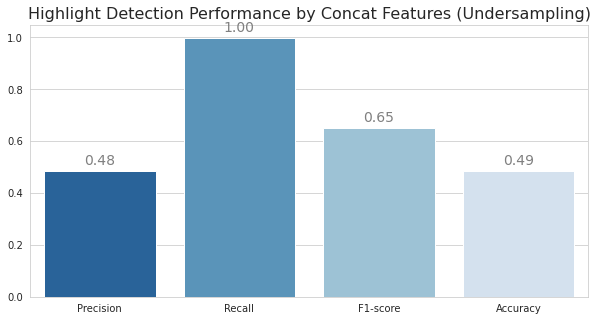

In [64]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('whitegrid')
plt.figure(figsize=(10,5))
ax = sns.barplot(x=['Precision', 'Recall', 'F1-score', 'Accuracy'], y=[precision, recall, f1, accuracy], palette='Blues_r')
plt.title('Highlight Detection Performance by Concat Features (Undersampling)', fontsize=16)
for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}", (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', fontsize=14, color='gray', xytext=(0, 10), 
                textcoords='offset points')
plt.show()


# model save

In [62]:
%cd /workspace/EmotionShortForm/lstm

/workspace/EmotionShortForm/lstm


In [63]:
PATH = 'multimodal_model.pt'

# 모델 저장
torch.save(model.state_dict(), PATH)